In [19]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from control.matlab import tf, step, lsim


%matplotlib inline

In [20]:
# Constants
NA = 6
NB = 6
ALPHA = 10e6

In [21]:
def read_mat(source:str) -> dict:
    data = scipy.io.loadmat(source)
    data = {k: v.flatten() for k, v in data.items() if not k.startswith("__")}
    return data

data1 = read_mat("/home/matthias/Downloads/ex2_system1_data.mat")
data2 = read_mat("/home/matthias/Downloads/ex2_system2_data.mat")

In [22]:
def calc_s_k(y:np.array,u:np.array,n_a,n_b, k):
    """ Construct the s_k vector
    
    Args:
        y (np.array): Output vector
        u (np.array): Input vector
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
    
    Returns:
        np.array: s_k vector
    """
    
    s_a = list(np.zeros(n_a))
    s_b = list(np.zeros(n_b +1))
    
    for i in range(k+1):
        index_a:int = k - i -1

        index_b:int = k - i

        if index_a >= 0:
            try:
                s_a[index_a] = float(y[i])
            except Exception:
                pass
        if index_b >= 0:
            try:
                s_b[index_b] = float(u[i])
            except Exception as e:
                pass
    
    s = s_a + s_b
    return s


In [58]:
def rec_least_squares(n_a:int, n_b:int,k:int, alpha:float, y:np.array, u:np.array, p_hat_k:np.array = None, P_k:np.array = None):
    """Recursive least squares algorithm

    Args:

    
    Returns:
        p_k (np.array): Parameter vector
        P_k (np.array): Covariance matrix
    """
    print(f"{k}")
    if k <= 0:
        p_init = np.zeros(n_a + n_b + 1).T
        P_init = np.eye(n_a + n_b + 1) * alpha
        return p_init, P_init
    
    s_k = np.array(calc_s_k(y,u,n_a,n_b,k)).T
    if p_hat_k is None or P_k is None:
        p_hat_k_1, P_k_1 = rec_least_squares(n_a, n_b, k-1, alpha, y, u)
    else:
        p_hat_k_1 = p_hat_k
        P_k_1 = P_k

    k_k = (np.dot(P_k_1, s_k)) / (1 + np.dot(s_k.T, np.dot(P_k_1, s_k)))
    if any(np.isnan(k_k)):
        print(f"NAN at {k}")
        raise Exception("NAN")
    P_K = P_k_1 - np.dot(k_k, np.dot(s_k.T, P_k_1))

    p_hat_k = p_hat_k_1 + k_k * (y[k] - np.dot(s_k.T, p_hat_k_1))

    return p_hat_k, P_K
    

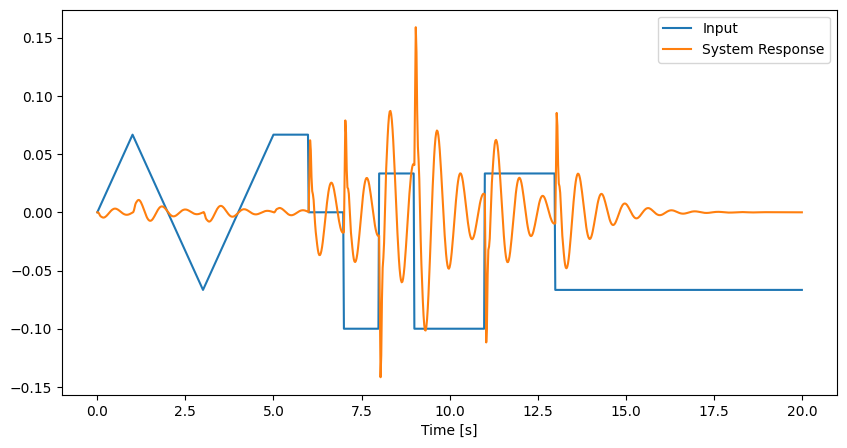

In [59]:
t = data1.get("t1")
u = data1.get("u1")
y = data1.get("y1")
plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()


In [60]:

pk_list = []
Pk_list = []

for i in range(len(t)):
    if i > 0:
        pk_1 = pk_list[-1]
        Pk_1 = Pk_list[-1]
        pk, Pk = rec_least_squares(NA, NB, i, ALPHA, y, u, pk_1, Pk_1)
    else:
        pk, Pk = rec_least_squares(NA, NB, i, ALPHA, y, u)
    
    pk_list.append(pk)
    Pk_list.append(Pk)
    if i > 1:
        dpest = pk_list[-1] - pk_list[-2]
        dnorm = np.linalg.norm(dpest)
        

p_hat = pk_list[-1]
print(p_hat)
Ts = t[1] - t[0]
Gest = tf(p_hat[NA:], [1] + [-p_hat[i] for i in range(NB)], Ts)


0
1
PK-1 [[10000000.        0.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.        0.]
 [       0. 10000000.        0.        0.        0.        0.        0.
         0.        0.        0.        0.        0.        0.]
 [       0.        0. 10000000.        0.        0.        0.        0.
         0.        0.        0.        0.        0.        0.]
 [       0.        0.        0. 10000000.        0.        0.        0.
         0.        0.        0.        0.        0.        0.]
 [       0.        0.        0.        0. 10000000.        0.        0.
         0.        0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.        0. 10000000.        0.
         0.        0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0. 10000000.
         0.        0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.     

Exception: NAN

In [44]:
y_test,_ , t_test = lsim(Gest, u, t)

/home/matthias/.local/lib/python3.10/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


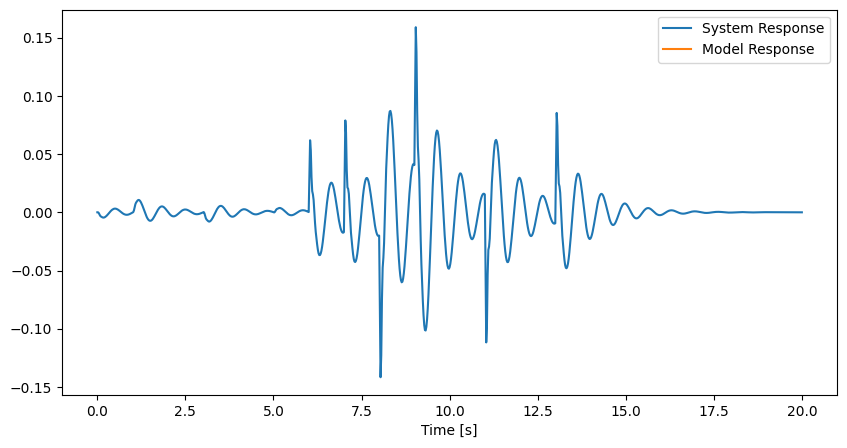

In [45]:

plt.figure(figsize=(10, 5))
plt.plot(t,y, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t, y_test,label="Model Response")
plt.legend()
plt.show()
